In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import glob
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [138]:
abril = pd.read_csv('Abril 2020.csv').drop('Unnamed: 0',axis = 1)
mayo = pd.read_csv('Mayo 2020.csv').drop('Unnamed: 0',axis = 1)
abril = abril[['Fecha','Hora','Potencia [kW]','Insolacion [W/m2]','Temperatura de modulos [C]']]
mayo = mayo[['Fecha','Hora','Potencia [kW]','Insolacion [W/m2]','Temperatura de modulos [C]']]
abril.head()

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C]
0,1/04/2020,6:00,0.00,2.02,12.17
1,1/04/2020,6:05,0.00,3.20,12.33
2,1/04/2020,6:10,0.01,4.51,12.39
3,1/04/2020,6:15,0.11,6.98,12.04
4,1/04/2020,6:20,0.24,10.52,11.79


In [128]:
mayo.head()

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C]
0,1/05/2020,6:00,0.00,2.51,11.78
1,1/05/2020,6:05,0.00,3.58,11.89
2,1/05/2020,6:10,0.01,4.80,11.83
3,1/05/2020,6:15,0.06,6.13,12.01
4,1/05/2020,6:20,0.11,7.46,12.10


In [139]:
# Reemplazo de los valores de potencia iguales a 0.00
horas = abril.Hora.unique()
horas = horas[0:12].tolist()+horas[132:144].tolist()

for h in horas:
        abril = abril[abril.Hora!= h]
abril.set_index(np.array(range(3600)),inplace = True)

In [136]:
mayo

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C]
0,1/05/2020,6:00,0.00,2.51,11.78
1,1/05/2020,6:05,0.00,3.58,11.89
2,1/05/2020,6:10,0.01,4.80,11.83
3,1/05/2020,6:15,0.06,6.13,12.01
4,1/05/2020,6:20,0.11,7.46,12.10
...,...,...,...,...,...
4459,31/05/2020,17:35,0.06,5.98,14.05
4460,31/05/2020,17:40,0.04,5.36,13.62
4461,31/05/2020,17:45,0.02,4.83,13.58
4462,31/05/2020,17:50,0.00,4.44,13.73


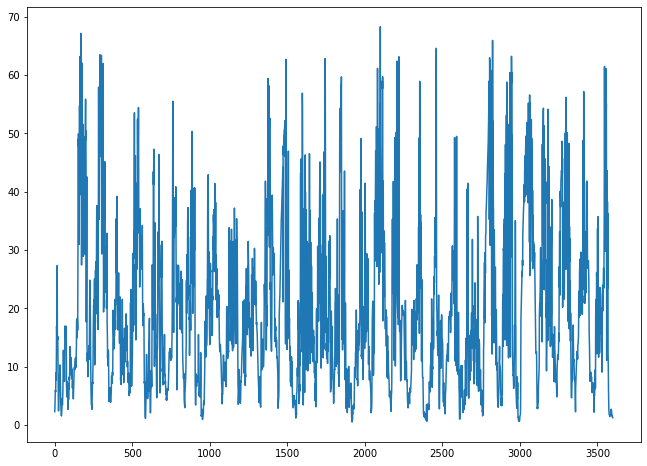

In [143]:
abril['Potencia [kW]'].plot(figsize = (11,8))

### Función de auto correlación y de autocorrelación parcial

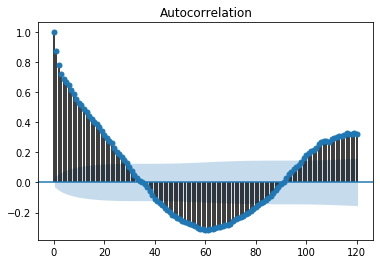

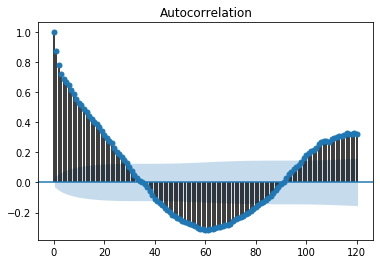

In [144]:
plot_acf(abril['Potencia [kW]'], lags =120)

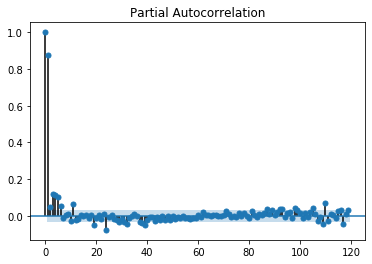

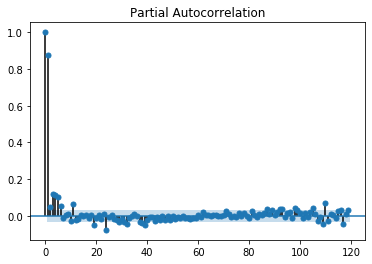

In [146]:
plot_pacf(abril['Potencia [kW]'], lags = np.arange(120))

### Se observa que los datos a tratar son no estacionarios, se procede a realizar la conversión a datos estacionarios

0.0002135936819724516

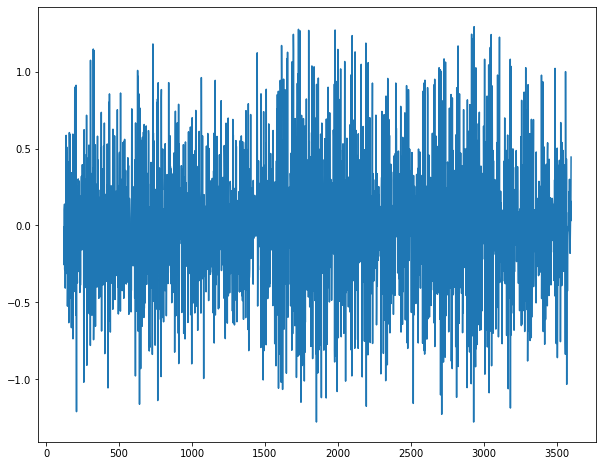

In [155]:
abril_log = np.log(abril['Potencia [kW]'])
abril_diff1 = abril_log.diff(1)
abril_diff_120 = abril_diff1.diff(120)

for i in range(len(abril_diff_120)):
    if np.absolute(abril_diff_120[i])>1.3:
        abril_diff_120[i]=abril_diff_120.mean()
abril_diff_120.plot(figsize=(10,8))
abril_diff_120.mean()

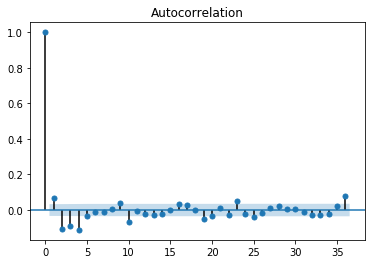

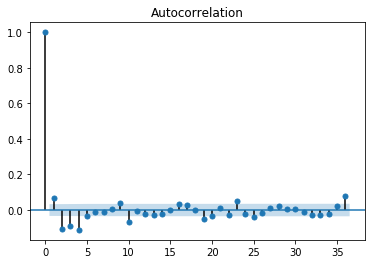

In [160]:
plot_acf(abril_diff_120[121:])

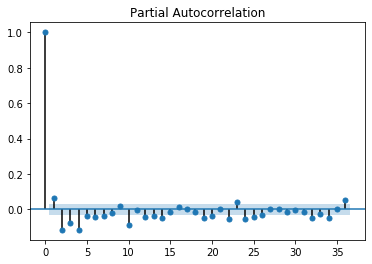

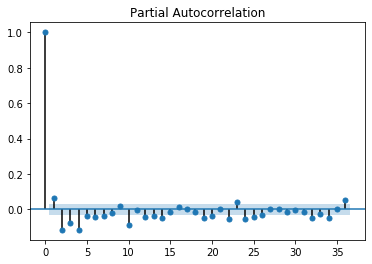

In [161]:
plot_pacf(abril_diff_120[121:])